# CRNN 字符识别

## CRNN卷积循环网络

CRNN是一种的典型的端到端的场景文字识别模型，不同于之前的场景文字识别框架，CRNN将特征提取，序列建模以及转录整合到统一的模型框架中。CRNN拥有如下特性：

- 端到端训练，不需要进行单独训练和协调
- 处理任意长度的文本，不需要进行字符分割或水平尺度归一化
- 无词典和基于词典的识别证明，CRNN不局限于任何预定义的词汇
- 模型大小合适，在场景中的效果表现良好

在场景文字中，文字以序列的形式出现，识别文字序列需要系统预测一系列对象标签，所以文字识别问题可以看作是序列识别问题。文本的长度也就是序列的长度可能会有很大变化，我们在案例中以CTW街景文字为背景，街道上的广告牌，标语，从简单的单字到复杂的长句可能出现各种不同的文字长度。之前的序列识别中，一种方法为对文字进行分割，将不定长度的序列分割为单字，然后对单字进行识别，这种方法对字符分割的要求更为严格。而另一种方法为将序列识别划分为分类问题，将接近9万个英文单词作为类标签。这种方法可能适合英文字符识别，但是对于汉语中，单字数量多，单词间没有空白的情况显然不能适用。

案例中使用的CRNN是一种结合了CNN和RNN的神经网络模型，称为卷积循环神经网络。相比较于传统的神经网络模型，CRNN具有一些优点：

- 利用CNN提取特征，更加准确，不需要机器学习中手动提起数据特征
- 利用RNN产生一系列标签
- 对数据高度进行归一化，但对数据长度没有要求

## CRNN 结构

![CRNN-pipline](./img/CRNN-2.png)

CRNN分为三部分：卷积层，循环层和转录层。 卷积层对图像进行特征提取操作，循环层生成序列标签，转录层将预测变为最终的序列标签。案例中使用了CTC（无词典的转录方式），不会被局限在预定义词汇范围中。

![CRNN-structure](./img/CRNN-1.png)

## CRNN 评估

在四个公共数据集：IIIT5k，SVT， IC03， IC13 上获得的所有识别精度：
_“50”，“1k”，“50k”和“Full”表示使用的字典，“None”表示识别没有字典。_
![CRNN-evaluation](./img/CRNN-3.png)

### 准备源代码和数据

这一步准备案例所需的源代码和数据，相关资源已经保存在OBS中，我们通过ModelArts SDK将资源下载到本地，并解压到当前目录下。

In [ ]:
from modelarts.session import Session
session = Session()
session.download_data(bucket_path="modelarts-labs/notebook/DL_sequence_recognition/sequence_recognition.tar.gz", path="./sequence_recognition.tar.gz")
# 使用tar命令解压资源包
!tar xvf ./sequence_recognition.tar.gz

1. 引入相关的包

In [ ]:
!pip install --upgrade opencv-python
!pip install keras==2.1.6
!pip install tensorflow-gpu==1.8

In [1]:
import keys as keys

import os
import numpy as np
from PIL import Image
from keras.layers import Flatten, BatchNormalization, Permute, TimeDistributed, Dense, Bidirectional, GRU
from keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model
from keras import backend as K
from keras.layers import Lambda
from keras.optimizers import SGD

Using TensorFlow backend.


2. 定义模型结构

In [2]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [3]:
def get_model(height, nclass, learning_rate):
    rnnunit = 256
    input = Input(shape=(height, None, 1), name='the_input')
#     卷积层
    m = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv1')(input)
    m = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1')(m)
    m = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='conv2')(m)
    m = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2')(m)
    m = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='conv3')(m)
    m = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='conv4')(m)

    m = ZeroPadding2D(padding=(0, 1))(m)
    m = MaxPooling2D(pool_size=(2, 2), strides=(2, 1), padding='valid', name='pool3')(m)

    m = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='conv5')(m)
    m = BatchNormalization(axis=1)(m)
    m = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='conv6')(m)
    m = BatchNormalization(axis=1)(m)
    m = ZeroPadding2D(padding=(0, 1))(m)
    m = MaxPooling2D(pool_size=(2, 2), strides=(2, 1), padding='valid', name='pool4')(m)
    m = Conv2D(512, kernel_size=(2, 2), activation='relu', padding='valid', name='conv7')(m)

    m = Permute((2, 1, 3), name='permute')(m)
    m = TimeDistributed(Flatten(), name='timedistrib')(m)
#     循环层
    m = Bidirectional(GRU(rnnunit, return_sequences=True), name='blstm1')(m)
    m = Dense(rnnunit, name='blstm1_out', activation='linear')(m)
    m = Bidirectional(GRU(rnnunit, return_sequences=True), name='blstm2')(m)

    y_pred = Dense(nclass, name='blstm2_out', activation='softmax')(m)

    basemodel = Model(inputs=input, outputs=y_pred)
    labels = Input(name='the_labels', shape=[None, ], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
#     CTC转录层
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    model = Model(inputs=[input, labels, input_length, label_length], outputs=[loss_out])
    sgd = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    return model, basemodel

In [4]:
def decode(pred):
    charactersS = characters + u' '
    t = pred.argmax(axis=2)[0]
    length = len(t)
    char_list = []
    n = len(characters)
    for i in range(length):
        if t[i] != n and (not (i > 0 and t[i - 1] == t[i])):
            char_list.append(charactersS[t[i]])
    return u''.join(char_list)

In [5]:
characters = keys.alphabet[:]
nclass=len(characters)+1
height = 32
model, basemodel = get_model(height, nclass, learning_rate=0.0001)

modelPath = './models/model_crnn.h5'                     
basemodel.load_weights(modelPath)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


调用summary函数，可以看到构架出的模型结构：

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 32, None, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, None, 64) 640         the_input[0][0]                  
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 16, None, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 16, None, 128 73856       pool1[0][0]                      
__________________________________________________________________________________________________
pool2 (Max

3. 测试图片尺寸重新调整

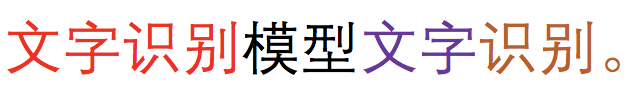

In [7]:
img = Image.open('./test_image.png')
img

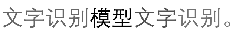

In [8]:
img = img.convert('L')
scale = img.size[1] * 1.0 / 32
w = img.size[0] / scale
w = int(w)
img = img.resize((w, 32))
img

4. 将测试图片传入模型进行字符预测，获得预测结果

In [9]:
img = np.array(img).astype(np.float32) / 255.0
X = img.reshape((32, w, 1))
X = np.array([X])
y_pred = basemodel.predict(X)
y_pred

array([[[7.32723276e-14, 5.90867133e-09, 3.72121564e-14, ...,
         2.45357519e-11, 4.12480716e-09, 5.87536611e-15],
        [5.70836645e-14, 7.45682893e-09, 3.29477554e-14, ...,
         2.23865336e-11, 3.23749738e-09, 3.16329502e-14],
        [6.08330254e-14, 1.10404965e-08, 8.85024137e-14, ...,
         4.48241409e-11, 1.15610312e-08, 3.29465136e-11],
        ...,
        [2.34782913e-18, 5.73790634e-20, 1.56465448e-17, ...,
         1.57386582e-19, 4.74277041e-15, 9.99999881e-01],
        [1.45687196e-18, 5.85361873e-21, 2.30722645e-19, ...,
         3.51459551e-21, 9.96941474e-16, 1.00000000e+00],
        [9.89614003e-15, 1.16845672e-18, 3.03500541e-17, ...,
         4.78296872e-19, 4.07981508e-15, 1.00000000e+00]]], dtype=float32)

In [10]:
y_pred = y_pred[:, 2:, :]
out = decode(y_pred)

if len(out) > 0:
    while out[0] == u'。':
        if len(out) > 1:
            out = out[1:]
        else:
            break

In [11]:
print("预测结果为：\""+out+"\"")

预测结果为："文字识别模型文字识别。"
